In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import skimage
from skimage import data, color, transform
from skimage.color import rgb2gray
from skimage.filters import meijering, sato, frangi, hessian
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches,
                             hessian_matrix, hessian_matrix_eigvals,
                             hog, SIFT)
from skimage.transform import ProjectiveTransform, SimilarityTransform, warp
from skimage.measure import ransac
from skimage.io import imread, imshow, imsave

import cv2
import helpers

%load_ext autoreload
%autoreload 2

# Load the data

In [16]:
def remove_circle(img):
    center = (int(img.shape[1]/2), int(img.shape[0]/2))
    radius = int(img.shape[0]/2) - 100
    mask = np.zeros(img.shape[:2], dtype="uint8")
    cv2.circle(mask, center, radius, 255, -1)
    return cv2.bitwise_and(img, img, mask=mask)

def preproc(img):
    img = rgb2gray(img)
    return remove_circle(img)

In [60]:
REGISTERED_DIR = './full_output/'
DATA_DIR = "/data/ml4s2021/data/2021_11_12/OphtalmoLaus/"
OUTPUT_DIR = "./output/"

images_df = helpers.load_df(DATA_DIR)

grouped_df = images_df.groupby(['patient_id', 'eye', 'centrage'], as_index=False)

target_df = grouped_df.first()
target_df[target_df['patient_id'] == '1']

df = pd.merge(
    target_df,
    images_df,
    how='inner',
    on=['patient_id', 'eye', 'centrage'],
    suffixes=('_target', '_source')
)
df = df[df['num_target'] != df['num_source']]
print(df.shape)
print(df.columns)

(1984, 7)
Index(['patient_id', 'eye', 'centrage', 'num_target', 'path_target',
       'num_source', 'path_source'],
      dtype='object')


# Evaluating results

In [59]:
df['target-source-nmi'] = np.nan
df['target-moved-nmi'] = np.nan

df['target-source-mse'] = np.nan
df['target-moved-mse'] = np.nan

df['target-source-structsim'] = np.nan
df['target-moved-structsim'] = np.nan

tot = 0
last_loaded_path_target = ''
for idx, row in df.iterrows():
    print('n ' + str(tot), end='\r')
    tot += 1
    try:
        if last_loaded_path_target != row['path_target']:
            target = preproc(imread(DATA_DIR+row['path_target']))
            last_loaded_path_target = row['path_target']
        source = preproc(imread(DATA_DIR+row['path_source']))
        folder = REGISTERED_DIR+f"{row['patient_id']}-{row['eye']}-{row['centrage']}/"
        moved = preproc(imread(folder+row['path_source']))
    except Exception:
        continue
    
    target_source_nmi = skimage.metrics.normalized_mutual_information(target, source)
    target_moved_nmi = skimage.metrics.normalized_mutual_information(target, moved)
    df.loc[idx, 'target-source-nmi'] = target_source_nmi
    df.loc[idx, 'target-moved-nmi'] = target_moved_nmi
    
    target_source_mse = skimage.metrics.mean_squared_error(target, source)
    target_moved_mse = skimage.metrics.mean_squared_error(target, moved)
    df.loc[idx, 'target-source-mse'] = target_source_mse
    df.loc[idx, 'target-moved-mse'] = target_moved_mse
    
    target_source_structsim = skimage.metrics.structural_similarity(target, source)
    target_moved_structsim = skimage.metrics.structural_similarity(target, moved)
    df.loc[idx, 'target-source-structsim'] = target_source_structsim
    df.loc[idx, 'target-moved-structsim'] = target_moved_structsim
    
    if tot == 500:
        break

print("\ndone")

Idx 885
done


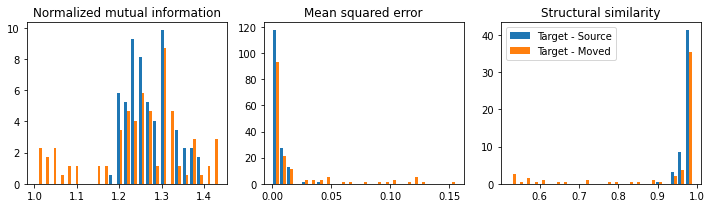

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax0, ax1, ax2 = ax.flatten()

bins=25

ax0.hist(df[['target-source-nmi', 'target-moved-nmi']], bins, density=True, histtype='bar', label=['Target - Source', 'Target - Moved'])
ax0.set_title('Normalized mutual information')

ax1.hist(df[['target-source-mse', 'target-moved-mse']], bins, density=True, histtype='bar', label=['Target - Source', 'Target - Moved'])
ax1.set_title('Mean squared error')

ax2.hist(df[['target-source-structsim', 'target-moved-structsim']], bins, density=True, histtype='bar', label=['Target - Source', 'Target - Moved'])
ax2.legend(prop={'size': 10})
ax2.set_title('Structural similarity')

fig.tight_layout()
plt.show()

As we can see, it seems that some of the moved image give *very* bad results. We can see them in the registred image folders for some registration sets.

Still, we can also see that registration gives good results on all other case.

To sum up, the registration can:

- not work at all
- give good results

If we take a look at the case where it doesn't work, we can understand that vessels are harder to extract. We could try to find hyperparameters that suit well for these cases too, or make some of them dynamics (for example the background suppression).

In [51]:
print("Mutual information - mean")
print(f"Target - Source : {df['target-source-nmi'].mean():.3f}")
print(f"Target - Moved  : {df['target-moved-nmi'].mean():.3f}")

print('\n-- Other metrics --')

print("\nMean squared error - mean")
print(f"Target - Source : {df['target-source-mse'].mean():.3f}")
print(f"Target - Moved  : {df['target-moved-mse'].mean():.3f}")

print("\nStructural similarity - mean")
print(f"Target - Source : {df['target-source-structsim'].mean():.3f}")
print(f"Target - Moved  : {df['target-moved-structsim'].mean():.3f}")

Mutual information - mean
Target - Source : 1.272
Target - Moved  : 1.246

-- Other metrics --

Mean squared error - mean
Target - Source : 0.005
Target - Moved  : 0.020

Structural similarity - mean
Target - Source : 0.973
Target - Moved  : 0.906


Next thing we can do is looking at the gain we obtain, i.e. the difference between the target-source metric and the target-moved metric.

In [52]:
df['gain-nmi'] = df['target-moved-nmi'] - df['target-source-nmi']
df['gain-mse'] = df['target-moved-mse'] - df['target-source-mse']
df['gain-structsim'] = df['target-moved-structsim'] - df['target-source-structsim']

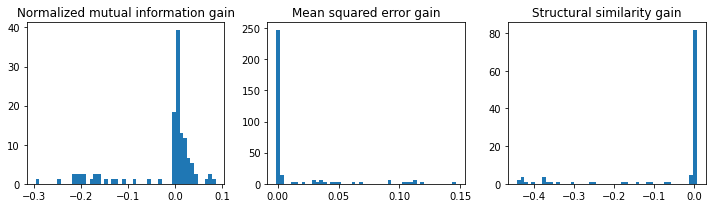

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax0, ax1, ax2 = ax.flatten()

bins=50

ax0.hist(df['gain-nmi'], bins, density=True, histtype='bar')
ax0.set_title('Normalized mutual information gain')

ax1.hist(df['gain-mse'], bins, density=True, histtype='bar',)
ax1.set_title('Mean squared error gain')

ax2.hist(df['gain-structsim'], bins, density=True, histtype='bar')
ax2.set_title('Structural similarity gain')

fig.tight_layout()
plt.show()

These results confirm what we said.

In [55]:
print("Mutual information")
print(f"Mean gain : {df['gain-nmi'].mean():.3f}")

print('\n-- Other metrics --')

print("\nMean squared error")
print(f"Mean gain : {df['gain-mse'].mean():.3f}")

print("\nStructural similarity")
print(f"Mean gain : {df['gain-structsim'].mean():.3f}")

Mutual information
Mean gain : -0.026

-- Other metrics --

Mean squared error
Mean gain : 0.015

Structural similarity
Mean gain : -0.067
